# Building Neural Networks

In [1]:
! pip install scikeras
! pip install bayesian-optimization

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.optimizers import Adam
from scipy import stats
from scikeras.wrappers import KerasRegressor, KerasClassifier
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

## 1. Hitters Dataset

The first dataset is the statistics of baseball hitters, such as times of home runs.

In [3]:
hitters = pd.read_csv('Hitters.csv')
hitters.isnull().sum()
hitters.duplicated().sum()

0

In [4]:
hitters.shape

(322, 20)

In [5]:
print(hitters.head())

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N  


### Data Preprocessing


We will perform data cleaning, including checking null values, remove outliers, and split the data into train and test set so that it is machine-learning ready.

In [6]:
num_col = hitters.select_dtypes(include=[np.number]).columns
cat_col = hitters.select_dtypes(include=[np.object]).columns

/var/folders/48/fj63g_z96ld2348rsn9_gs500000gn/T/ipykernel_51564/1287965811.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_col = hitters.select_dtypes(include=[np.object]).columns


In [7]:
hitters.isna().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [8]:
#impute missing values using simple imputer
imputer = SimpleImputer(strategy='mean')
hitters[num_col] = imputer.fit_transform(hitters[num_col])

In [9]:
#check nan values
nan = hitters.isna()
print(nan.sum())

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64


In [10]:
#remove outliers of numerical variables using IQR
numerical = hitters[num_col]
category = hitters[cat_col]
print(numerical.head())

   AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat   CHits  CHmRun  \
0  293.0   66.0    1.0  30.0  29.0   14.0    1.0   293.0    66.0     1.0   
1  315.0   81.0    7.0  24.0  38.0   39.0   14.0  3449.0   835.0    69.0   
2  479.0  130.0   18.0  66.0  72.0   76.0    3.0  1624.0   457.0    63.0   
3  496.0  141.0   20.0  65.0  78.0   37.0   11.0  5628.0  1575.0   225.0   
4  321.0   87.0   10.0  39.0  42.0   30.0    2.0   396.0   101.0    12.0   

   CRuns   CRBI  CWalks  PutOuts  Assists  Errors      Salary  
0   30.0   29.0    14.0    446.0     33.0    20.0  535.925882  
1  321.0  414.0   375.0    632.0     43.0    10.0  475.000000  
2  224.0  266.0   263.0    880.0     82.0    14.0  480.000000  
3  828.0  838.0   354.0    200.0     11.0     3.0  500.000000  
4   48.0   46.0    33.0    805.0     40.0     4.0   91.500000  


In [11]:
#remove outliers using z-score
z = np.abs(stats.zscore(numerical))
threshold = 3
hitters = hitters[(z < 3).all(axis=1)]
print(hitters.shape)

(287, 20)


In [12]:
#split into train and test
X_hitters = hitters.drop('Salary',axis=1)
y_hitters = hitters['Salary']


In [13]:
X_train_hitters, X_test_hitters, y_train_hitters, y_test_hitters = train_test_split(X_hitters, y_hitters, test_size=0.2, random_state=42)

In [14]:
num_col = num_col.drop('Salary')

In [15]:
# Normalize targets
y_train_hitters = (y_train_hitters - np.mean(y_train_hitters)) / np.std(y_train_hitters)
y_test_hitters = (y_test_hitters - np.mean(y_train_hitters)) / np.std(y_train_hitters)  # Use train mean and std

#normalize numerical variables
scaler = StandardScaler()
X_train_hitters[num_col] = scaler.fit_transform(X_train_hitters[num_col])
X_test_hitters[num_col] = scaler.transform(X_test_hitters[num_col])

In [16]:
#use category endcoding to convert categorical variables to numerical
encoder = LabelEncoder()
X_train_hitters['Division'] = encoder.fit_transform(X_train_hitters['Division'])
X_test_hitters['Division'] = encoder.transform(X_test_hitters['Division'])

X_train_hitters['League'] = encoder.fit_transform(X_train_hitters['League'])
X_test_hitters['League'] = encoder.transform(X_test_hitters['League'])

X_train_hitters['NewLeague'] = encoder.fit_transform(X_train_hitters['NewLeague'])
X_test_hitters['NewLeague'] = encoder.transform(X_test_hitters['NewLeague'])



### Initial Neural Network Model

- For the activation function of hiddens layers, we chose ReLu because it is often used for activation of hiddens layers, where speed and efficiency are crucial. In the hidden layers, ReLU is effective in converting linear combinations of inputs into non-linear outputs, which can help to capture more complex relationships. He uniform is used as weight initializer since it is suitable for ReLu activation.

- For output layer of Hitters dataset neural network, we used linear activation (identity function) because the purpose is to predict the salary of baseball players' salaries. 

- For the cost function, we chose MSE, it’s suitable for regression tasks as it directly measures the average squared difference between the predicted and actual values. It penalizes large errors more significantly, which is helpful in focusing the model on reducing significant errors.

- For optimization method, Adam is chosen because it adapts learning rates of each parameter, which helps in faster convergence and better performance. We could also use RMSProp as optimization.

Furthermore, we added Batch Normalization, weight regularizers, set drop out rate and learning rate to improve the performance of model.

In [17]:
def hitters_model(wd=0.01,weight_initializer='he_uniform', learning_rate=0.01,
              activation = 'relu',drop_rate=0.3,layers=3, hidden_units=128):
    model = Sequential()
    model.add(Input(shape=(X_train_hitters.shape[1],)))
    model.add(Dense(256,kernel_initializer=weight_initializer))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(drop_rate))
    for i in range(layers):
        model.add(Dense(hidden_units,kernel_initializer=weight_initializer,kernel_regularizer=regularizers.l2(wd)))
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(drop_rate))
    model.add(Dense(1))
    model.add(Activation('linear'))
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model


In [18]:

model = hitters_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,729 (288.00 KB)

 Trainable params: 72,449 (283.00 KB)

 Non-trainable params: 1,280 (5.00 KB)

In [19]:

history_hitters=model.fit(X_train_hitters, y_train_hitters, epochs=200, validation_split=0.1, batch_size=64, verbose=False)
model.evaluate(X_test_hitters, y_test_hitters, verbose=2)

2/2 - 0s - 4ms/step - loss: 289053.6250 - mae: 468.6694


[289053.625, 468.6694030761719]

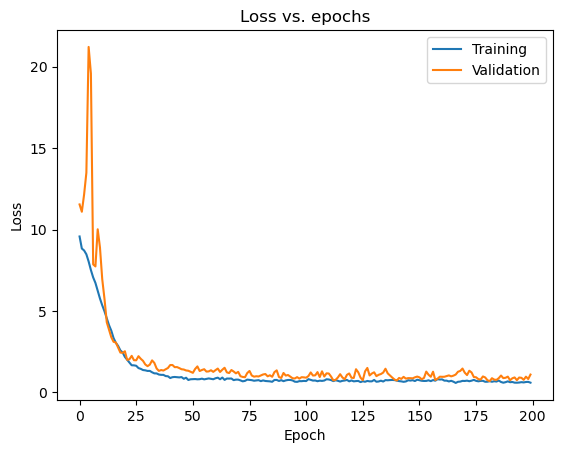

In [20]:
# Plot the training and validation loss
plt.plot(history_hitters.history['loss'])
plt.plot(history_hitters.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

### Callback

In [21]:
# Write a custom callback
class MyTrainingCallback(Callback):
  def on_train_begin(self, logs=None):
    print("Training starting...")
  def on_epoch_begin(self, epoch, logs=None):
    print(f"Starting epoch {epoch}")
  def on_train_batch_begin(self, batch, logs=None):
    print(f"Training: Starting batch {batch}")
  def on_train_batch_end(self, batch, logs=None):
    print(f"Traing: Finished batch {batch}")
  def on_epoch_end(self, epoch, logs=None):
    print(f"Finished epoch {epoch}")
  def on_train_end(self, logs=None):
    print("Finished training:")

In [22]:
class MyTrainingCallback2(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            if logs.get('val_loss') < 0.1:  # Custom condition to stop training early
                print("\nReached a validation loss below 0.1, stopping training")
                self.model.stop_training = True

In [23]:
# Re-build the model
model=hitters_model()

In [24]:
#compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# Train the model with the callback
#Train the model, with some of the data reserved for validation
model.fit(X_train_hitters, y_train_hitters, epochs=5,validation_split=0.1, batch_size=64,
          verbose=False, callbacks=[MyTrainingCallback()])

Training starting...
Starting epoch 0
Training: Starting batch 0
Traing: Finished batch 0
Training: Starting batch 1
Traing: Finished batch 1
Training: Starting batch 2
Traing: Finished batch 2
Training: Starting batch 3
Traing: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Traing: Finished batch 0
Training: Starting batch 1
Traing: Finished batch 1
Training: Starting batch 2
Traing: Finished batch 2
Training: Starting batch 3
Traing: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Traing: Finished batch 0
Training: Starting batch 1
Traing: Finished batch 1
Training: Starting batch 2
Traing: Finished batch 2
Training: Starting batch 3
Traing: Finished batch 3
Finished epoch 2
Starting epoch 3
Training: Starting batch 0
Traing: Finished batch 0
Training: Starting batch 1
Traing: Finished batch 1
Training: Starting batch 2
Traing: Finished batch 2
Training: Starting batch 3
Traing: Finished batch 3
Finished epoch 3
Starting ep

Next, we use Grid Search and Bayesian Optimization to obtain the optimal parameters.

### Grid Search

In [26]:
model = KerasRegressor(model=hitters_model,epochs=50, batch_size=64, verbose=0)

In [27]:
#set different parameters for grid search
param_grid = {
   # 'batch_size': [64, 128],
   # 'epochs': [40, 50],
    'model__learning_rate': [0.001, 0.01],
    'model__wd' : [0.01, 0.001],
    'model__layers': [1, 2, 3],
    'model__hidden_units': [64, 128],
    'model__activation': ['relu', 'tanh'],
    'model__drop_rate': [0.2, 0.3]
}

In [28]:
#perform girid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0,
                    scoring='neg_mean_squared_error')


In [29]:
grid.fit(X_train_hitters, y_train_hitters,verbose=0)

GridSearchCV(cv=5,
             estimator=KerasRegressor(batch_size=64, epochs=50, model=<function hitters_model at 0x17295dda0>, verbose=0),
             param_grid={'model__activation': ['relu', 'tanh'],
                         'model__drop_rate': [0.2, 0.3],
                         'model__hidden_units': [64, 128],
                         'model__layers': [1, 2, 3],
                         'model__learning_rate': [0.001, 0.01],
                         'model__wd': [0.01, 0.001]},
             scoring='neg_mean_squared_error')

In [30]:
best_parameters = grid.best_params_
best_score = grid.best_score_

print("Best Parameters: " + str(best_parameters),"\n")
print("Best Score: " + str(best_score),"\n")

Best Parameters: {'model__activation': 'relu', 'model__drop_rate': 0.3, 'model__hidden_units': 64, 'model__layers': 3, 'model__learning_rate': 0.01, 'model__wd': 0.001} 

Best Score: -0.4859067860503865 



### Bayes Optimization

In [91]:
def bayes_hitters(wd=0.001,weight_initializer='he_uniform', learning_rate=0.01,
              activation = 'relu',drop_rate=0.5,layers=3, hidden_units=128, epochs=20, batch_size=64):
    wd = 10**wd
    learning_rate = 10**learning_rate
    layers = round(layers)
    hidden_units = round(hidden_units)
    epochs = round(epochs)
    batch_size = round(batch_size)
    def bayes_model():
          model = Sequential()
          model.add(Input(shape=(X_train_hitters.shape[1],)))
          model.add(Dense(256,kernel_initializer=weight_initializer))
          model.add(BatchNormalization())
          model.add(Activation(activation))
          model.add(Dropout(drop_rate))
          for i in range(layers):
              model.add(Dense(hidden_units,kernel_initializer=weight_initializer,kernel_regularizer=regularizers.l2(wd)))
              model.add(BatchNormalization())
              model.add(Activation(activation))
              model.add(Dropout(drop_rate))
          model.add(Dense(1))
          model.add(Activation('linear'))
          opt = Adam(learning_rate=learning_rate)
          model.compile(optimizer=opt, loss='mse', metrics=['mae'])
          return model

    model = KerasRegressor(model=bayes_model, epochs=epochs, batch_size=batch_size, verbose=0)
    score = cross_val_score(model,X_train_hitters, y_train_hitters, cv=5,scoring='neg_mean_squared_error').mean()
    return score


In [92]:
# add log10 to scale the weight decay and learning rate to make them equally spread
pounds = {'wd': (np.log10(0.0001), np.log10(0.01)),
           'layers': (1, 4),
           'hidden_units': (50, 200),
           'batch_size': (50,200),
            'epochs': (20, 200),
            'learning_rate': (np.log10(0.0001), np.log10(0.01)),
           'drop_rate': (0.1, 0.6)}


In [93]:

optimizer = BayesianOptimization(
    f=bayes_hitters,
    pbounds=pounds,
    random_state=42
)

In [94]:
#best parameters
optimizer.maximize(init_points=10,n_iter=4)
print(optimizer.max)

|   iter    |  target   | batch_... | drop_rate |  epochs   | hidden... |  layers   | learni... |    wd     |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.4985   | 106.2     | 0.5754    | 151.8     | 139.8     | 1.468     | -3.688    | -3.884    |
| 2         | -0.6295   | 179.9     | 0.4006    | 147.5     | 53.09     | 3.91      | -2.335    | -3.575    |
| 3         | -0.5167   | 77.27     | 0.1917    | 74.76     | 128.7     | 2.296     | -3.418    | -2.776    |
| 4         | -0.561    | 70.92     | 0.2461    | 85.95     | 118.4     | 3.356     | -3.601    | -2.972    |
| 5         | -0.5524   | 138.9     | 0.1232    | 129.4     | 75.58     | 1.195     | -2.102    | -2.069    |
| 6         | -0.7526   | 171.3     | 0.2523    | 37.58     | 152.6     | 2.32      | -3.756    | -3.01     |
| 7         | -0.5281   | 55.16     | 0.5547    | 66.58     | 149.4     | 1.935     | -2.96     | -2.907    |
| 8       

In [96]:
print("Best score " + str(optimizer.max['target']))
print("Best batch size: " + str(round(optimizer.max['params']['batch_size'])))
print("Best epochs: " + str(round(optimizer.max['params']['epochs'])))
print("Best layers: " + str(round(optimizer.max['params']['layers'])))
print("Best hidden units: " + str(round(optimizer.max['params']['hidden_units'])))
print("Best drop rate: " + str(optimizer.max['params']['drop_rate']))
print("Best learning rate: " + str(10**optimizer.max['params']['learning_rate']))
print("Best weight decay: " + str(10**optimizer.max['params']['wd']))

Best score -0.4979516069301916
Best batch size: 125
Best epochs: 132
Best layers: 1
Best hidden units: 123
Best drop rate: 0.407677445240774
Best learning rate: 0.0013700721173749617
Best weight decay: 0.0001


### Compare with Multiple Regression 

In [97]:
#compare with linear regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train_hitters, y_train_hitters)
y_pred = linreg.predict(X_test_hitters)
linreg_score = linreg.score(X_test_hitters, y_test_hitters)
print("Linear Regression Score: ", linreg_score)
#cross validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(linreg, X_train_hitters, y_train_hitters, cv=cv, scoring='neg_mean_squared_error')
print("Linear Regression Cross Validation MSE: ", scores.mean())

Linear Regression MSE:  468.7829703481209
Linear Regression Score:  -3.15603360102556
Linear Regression Cross Validation MSE:  -0.6628456243737745


- The score ($R^2$) of multiple linear regression is -3.156, which means the model does not follow the trend of data and is a bad fit. While the negative mean $MSE$ score from the cross-validation of grid search is -0.4859 with the best hyperparameters, and for Bayes optimization, it is approximately -0.4980 with the best hyperparameters. For multiple linear regression, it is -0.6628, which means the result of grid search and bayesian optimization is better than multiple linear regression.

We could conclude that after hyperparameter tuning, our neural network models performed better than linear regression model. 

## 2. Default Dataset

### Data Preprocessing

In [52]:
#import dataset named Default
df = pd.read_csv('Default.csv')
#display the first 5 rows of the dataset
print(df.head())
df.isnull().sum()

  default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879


default    0
student    0
balance    0
income     0
dtype: int64

In [53]:
df.duplicated().sum()

0

In [54]:
df.isna().sum()

default    0
student    0
balance    0
income     0
dtype: int64

In [55]:
df.shape

(10000, 4)

<Axes: xlabel='balance'>

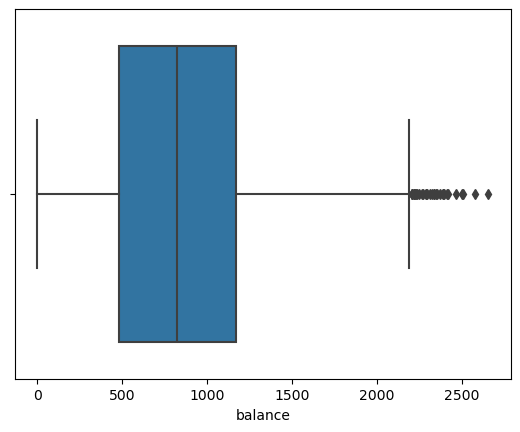

In [56]:
#detecting outliers
sns.boxplot(x=df['balance'])

<Axes: xlabel='income'>

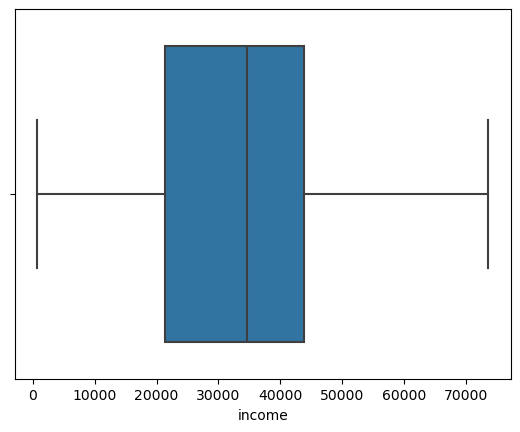

In [57]:
sns.boxplot(x=df['income'])


We can see from the boxplots that there are a few outliers for balance, while no outlier for income, so outliers from balance column will be removed.


In [58]:
#remove outliers from column 'balance' by using IQR
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
print(Q1)
IQR = Q3 - Q1
print(IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Lower bound:",lower_bound)
print("Upper bound:",upper_bound)
df = df[(df['balance'] > lower_bound) & (df['balance'] < upper_bound)].reset_index(drop=True)  
df.shape


481.731105054518
684.5772814213195
Lower bound: -545.1348170774612
Upper bound: 2193.174308607817


(9969, 4)

In [59]:
print(df)

     default student      balance        income
0         No      No   729.526495  44361.625074
1         No     Yes   817.180407  12106.134700
2         No      No  1073.549164  31767.138947
3         No      No   529.250605  35704.493935
4         No      No   785.655883  38463.495879
...      ...     ...          ...           ...
9964      No      No   711.555020  52992.378914
9965      No      No   757.962918  19660.721768
9966      No      No   845.411989  58636.156984
9967      No      No  1569.009053  36669.112365
9968      No     Yes   200.922183  16862.952321

[9969 rows x 4 columns]


<Axes: xlabel='balance'>

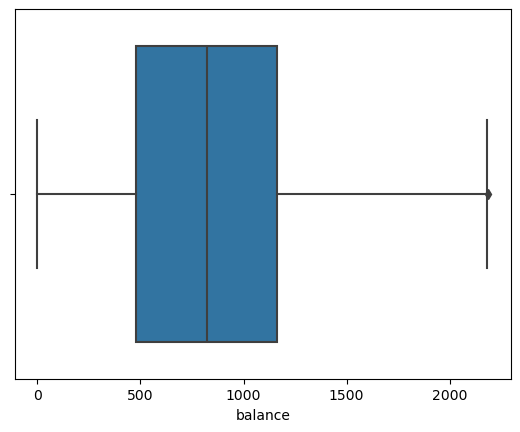

In [60]:
sns.boxplot(x=df['balance'])

In [61]:
#split the dataset into training and testing
X_default = df.drop('default', axis=1)
y_default = df['default']
X_train_default, X_test_default, y_train_default, y_test_default = train_test_split(X_default, y_default, test_size=0.2, random_state=123)

In [62]:
#Normalize numerical features of balance and income in train, then apply to test dataset
scaler = StandardScaler()
X_train_default[['balance', 'income']] = scaler.fit_transform(X_train_default[['balance', 'income']])
X_test_default[['balance', 'income']] = scaler.transform(X_test_default[['balance', 'income']])

encoder = LabelEncoder()
y_train_default = encoder.fit_transform(y_train_default)
y_test_default = encoder.transform(y_test_default)

X_train_default['student'] = encoder.fit_transform(X_train_default['student'])
X_test_default['student'] = encoder.transform(X_test_default['student'])

print(X_train_default.head())

      student   balance    income
9628        0 -1.723599  0.656265
9236        0  0.704125  1.062364
5829        0 -0.155833  1.183142
6290        0  0.027256 -0.717094
8945        0  0.024129  0.353783


### Building Neural Network Model

- Similar to the Hitters dataset, we will use a neural network to predict the default column. We will use the same model as the Hitters dataset, but we will change the output layer to a sigmoid activation function to predict the binary output.

- We use binary classification cost function for this problem.

In [63]:
def default_model(wd=0.001,weight_initializer='he_uniform', learning_rate=0.001,
              activation = 'relu',drop_rate=0.3,layers=3, hidden_units=64):
    model = Sequential()
    model.add(Input(shape=(X_train_default.shape[1],)))
    model.add(Dense(256,kernel_initializer=weight_initializer))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(drop_rate))
    for i in range(layers):
        model.add(Dense(hidden_units,kernel_initializer=weight_initializer,kernel_regularizer=regularizers.l2(wd)))
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(drop_rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [64]:
model = default_model()
model.summary()

Model: "sequential_568"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2265 (Dense)              │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1702        │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2255 (Activation)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1702 (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2266 (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1703        │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2256 (Activation)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1703 (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2267 (Dense)              │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1704        │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2257 (Activation)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1704 (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2268 (Dense)              │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1705        │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2258 (Activation)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1705 (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2269 (Dense)              │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2259 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,649 (108.00 KB)

 Trainable params: 26,753 (104.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [65]:
# Train the model, with some of the data reserved for validation
early_stopping = EarlyStopping(patience=5,monitor='val_loss',restore_best_weights=True)
history=model.fit(X_train_default, y_train_default, epochs=100, validation_split=0.2, batch_size=100, verbose=False)

In [66]:
# Evaluate the model on the test set
model.evaluate(X_test_default,y_test_default, verbose=2)

63/63 - 0s - 407us/step - accuracy: 0.9779 - loss: 0.0732


[0.0731646791100502, 0.9779338240623474]

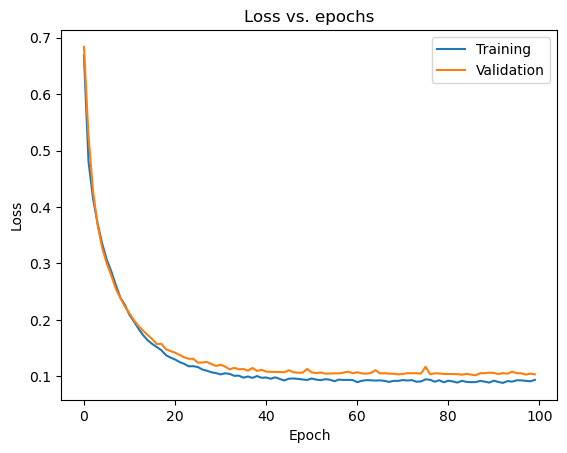

In [67]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### CallBack

In [68]:
# Write a custom callback
class MyTrainingCallback(Callback):
  def on_train_begin(self, logs=None):
    print("Training starting...")
  def on_epoch_begin(self, epoch, logs=None):
    print(f"Starting epoch {epoch}")
  def on_train_batch_begin(self, batch, logs=None):
    print(f"Training: Starting batch {batch}")
  def on_train_batch_end(self, batch, logs=None):
    print(f"Traing: Finished batch {batch}")
  def on_epoch_end(self, epoch, logs=None):
    print(f"Finished epoch {epoch}")
  def on_train_end(self, logs=None):
    print("Finished training:")

In [69]:
class MyTrainingCallback2(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            if logs.get('val_loss') < 0.1:  # Custom condition to stop training early
                print("\nReached a validation loss below 0.1, stopping training")
                self.model.stop_training = True

In [70]:
# Train the model with the callback
#Train the model, with some of the data reserved for validation
model.fit(X_train_default, y_train_default, epochs=5,validation_split=0.1, batch_size=64,
          verbose=False, callbacks=[MyTrainingCallback()])

Training starting...
Starting epoch 0
Training: Starting batch 0
Traing: Finished batch 0
Training: Starting batch 1
Traing: Finished batch 1
Training: Starting batch 2
Traing: Finished batch 2
Training: Starting batch 3
Traing: Finished batch 3
Training: Starting batch 4
Traing: Finished batch 4
Training: Starting batch 5
Traing: Finished batch 5
Training: Starting batch 6
Traing: Finished batch 6
Training: Starting batch 7
Traing: Finished batch 7
Training: Starting batch 8
Traing: Finished batch 8
Training: Starting batch 9
Traing: Finished batch 9
Training: Starting batch 10
Traing: Finished batch 10
Training: Starting batch 11
Traing: Finished batch 11
Training: Starting batch 12
Traing: Finished batch 12
Training: Starting batch 13
Traing: Finished batch 13
Training: Starting batch 14
Traing: Finished batch 14
Training: Starting batch 15
Traing: Finished batch 15
Training: Starting batch 16
Traing: Finished batch 16
Training: Starting batch 17
Traing: Finished batch 17
Training: 

### Grid Search

Because testing tuning all the parameters would take a long time, so we only tuned some of them and fix the epochs and batch size.

In [71]:
model = KerasClassifier(model=default_model, epochs =50, batch_size=64,verbose=0)

In [72]:
#set different parameters for grid search
param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'model__wd' : [0.01, 0.001],
    'model__layers': [1, 2, 3 ],
    'model__hidden_units': [64, 128],
    'model__drop_rate': [0.1, 0.3]
}

In [73]:
#perform girid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0)

In [74]:
grid.fit(X_train_default, y_train_default,verbose=0)

GridSearchCV(cv=5,
             estimator=KerasClassifier(batch_size=64, epochs=50, model=<function default_model at 0x54270e020>, verbose=0),
             param_grid={'model__drop_rate': [0.1, 0.3],
                         'model__hidden_units': [64, 128],
                         'model__layers': [1, 2, 3],
                         'model__learning_rate': [0.001, 0.01],
                         'model__wd': [0.01, 0.001]})

In [75]:
best_parameters = grid.best_params_
best_score = grid.best_score_

print("Best Parameters: " + str(best_parameters),"\n")
print("Best Score: " + str(best_score),"\n")

Best Parameters: {'model__drop_rate': 0.1, 'model__hidden_units': 64, 'model__layers': 1, 'model__learning_rate': 0.001, 'model__wd': 0.001} 

Best Score: 0.9719122257053291 



### Bayes Optimization

In [80]:
def bayes_default(wd=0.001,weight_initializer='he_uniform', learning_rate=0.01,
              activation = 'relu',drop_rate=0.5,layers=3, hidden_units=128, epochs=30, batch_size=128):
    wd = 10**wd
    learning_rate = 10**learning_rate
    epochs = round(epochs)
    hidden_units = round(hidden_units)
    batch_size = round(batch_size)
    layers = round(layers)
    def default_model():
          model = Sequential()
          model.add(Input(shape=(X_train_default.shape[1],)))
          model.add(Dense(256,kernel_initializer=weight_initializer))
          model.add(BatchNormalization())
          model.add(Activation(activation))
          model.add(Dropout(drop_rate))
          for i in range(layers):
             model.add(Dense(hidden_units,kernel_initializer=weight_initializer,kernel_regularizer=regularizers.l2(wd)))
             model.add(BatchNormalization())
             model.add(Activation(activation))
             model.add(Dropout(drop_rate))
          model.add(Dense(1))
          model.add(Activation('sigmoid'))
          opt = Adam(learning_rate=learning_rate)
          model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
          return model
    model = KerasClassifier(model=default_model, epochs=epochs, batch_size=batch_size, verbose=0)
    score = cross_val_score(model, X_train_default, y_train_default, cv=5, scoring='accuracy').mean()
    return score


In [81]:

pounds = {'wd': (np.log10(0.0001), np.log10(0.01)),
          'layers': (1, 4),
          'learning_rate': (np.log10(0.0001), np.log10(0.01)),
          'hidden_units': (50, 200),
           'batch_size': (50,300),
            'epochs': (50, 300),
           'drop_rate': (0.1, 0.6)}


In [82]:

optimizer = BayesianOptimization(
    f=bayes_default,
    pbounds=pounds,
    random_state=123
)

In [83]:
#best parameters
optimizer.maximize(init_points=10,n_iter=4)
print(optimizer.max)

|   iter    |  target   | batch_... | drop_rate |  epochs   | hidden... |  layers   | learni... |    wd     |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9715    | 224.1     | 0.2431    | 106.7     | 132.7     | 3.158     | -3.154    | -2.038    |
| 2         | 0.9715    | 221.2     | 0.3405    | 148.0     | 101.5     | 3.187     | -3.123    | -3.881    |
| 3         | 0.9692    | 149.5     | 0.469     | 95.62     | 76.32     | 2.595     | -2.936    | -2.731    |
| 4         | 0.9714    | 262.4     | 0.4622    | 202.8     | 158.4     | 1.969     | -3.276    | -3.543    |
| 5         | 0.9702    | 123.4     | 0.4155    | 73.03     | 115.1     | 2.293     | -3.013    | -3.148    |
| 6         | 0.9714    | 128.1     | 0.3132    | 273.3     | 191.6     | 2.506     | -2.752    | -3.769    |
| 7         | 0.9702    | 129.3     | 0.3074    | 266.6     | 87.57     | 2.449     | -2.029    | -2.961    |
| 8       

In [90]:
print("Best accuracy " + str(optimizer.max['target']))
print("Best Batch Size: " + str(round(optimizer.max['params']['batch_size'])))
print("Best Epochs: " + str(round(optimizer.max['params']['epochs'])))
print("Best dropout rate: " + str(optimizer.max['params']['drop_rate']))
print("Best hidden units: " + str(round(optimizer.max['params']['hidden_units'])))
print("Best layers: " + str(round(optimizer.max['params']['layers'])))
print("Best learning rate: " + str(10**optimizer.max['params']['learning_rate']))
print("Best weight decay: " + str(10**optimizer.max['params']['wd']))

Best accuracy 0.9722884012539185
Best Batch Size: 203
Best Epochs: 257
Best dropout rate: 0.16031433299516187
Best hidden units: 140
Best layers: 3
Best learning rate: 0.00048476099425358527
Best weight decay: 0.00040573416395168593


In [84]:
logreg = LogisticRegression()
logreg.fit(X_train_default, y_train_default)
score = logreg.score(X_test_default, y_test_default)
print(score)
log_pred = logreg.predict(X_test_default)
print(classification_report(y_test_default, log_pred))

0.9784353059177533
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1943
           1       0.72      0.25      0.38        51

    accuracy                           0.98      1994
   macro avg       0.85      0.63      0.68      1994
weighted avg       0.97      0.98      0.97      1994



- After hyperparameters tuning from grid search, we got the accuracy of 0.9719 with best parameters. The score for Bayes optimization is 0.9723 with best parameters. While for logistic regression, the accuracy is 0.9784. 

The logistic regression model has a higher accuracy than the neural network model.